In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import datetime
import gc
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error


import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb

%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso,LogisticRegression)
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


** The following function is based on https://www.kaggle.com/gemartin/load-data-reduce-memory-usage?fbclid=IwAR2PdhpX6JywVbJ84gZTngvXORMhP0t2hMXJZlrzktANha4Xf2YDPQqI538

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    

    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:

def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

# Data Importation


In [4]:
print('-' * 80)
print('building')
building = import_data('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')

print('-' * 80)
print('train')
train = import_data('/kaggle/input/ashrae-energy-prediction/train.csv')

print('-' * 80)
print('test')
test = import_data('/kaggle/input/ashrae-energy-prediction/test.csv')

print('-' * 80)
print('weather train')
weather_train = import_data('/kaggle/input/ashrae-energy-prediction/weather_train.csv')

print('-' * 80)
print('weather test')
weather_test = import_data('/kaggle/input/ashrae-energy-prediction/weather_test.csv')


--------------------------------------------------------------------------------
building
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.03 MB
Decreased by 60.3%
--------------------------------------------------------------------------------
train
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
--------------------------------------------------------------------------------
test
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%
--------------------------------------------------------------------------------
weather train
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 3.07 MB
Decreased by 68.1%
--------------------------------------------------------------------------------
weather test
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 6.08 MB
Decreased by 68.1%


In [5]:
building.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
site_id,1449.0,6.952381e+00,5.003432,0.0,3.0,5.0,13.0,15.0
building_id,1449.0,7.240000e+02,418.434583,0.0,362.0,724.0,1086.0,1448.0
square_feet,1449.0,9.211178e+04,110769.950997,283.0,23012.0,57673.0,115676.0,875000.0
year_built,675.0,inf,31.062500,1900.0,1949.0,1970.0,1995.0,2017.0
floor_count,355.0,3.740234e+00,3.333984,1.0,1.0,3.0,5.0,26.0


In [6]:
# check missing values in building data
missing_statistics(building)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,site_id,0,1449,0.00
1,building_id,0,1449,0.00
2,primary_use,0,1449,0.00
3,square_feet,0,1449,0.00
4,year_built,774,1449,53.42
5,floor_count,1094,1449,75.50


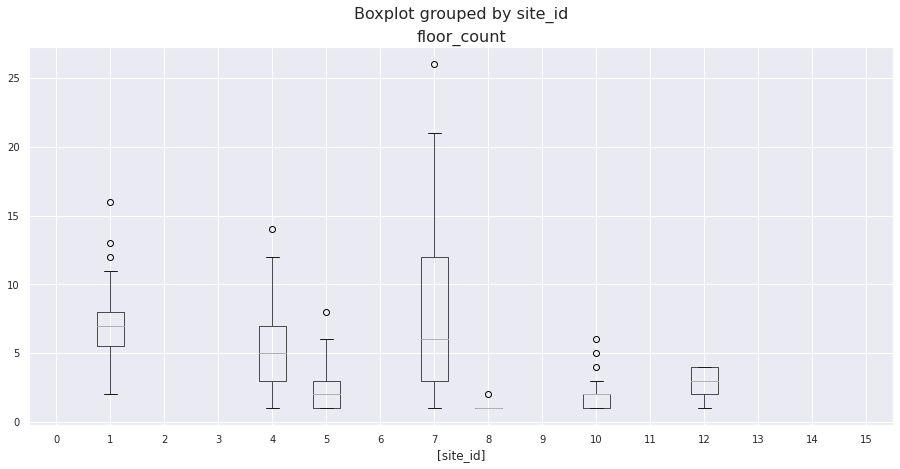

In [7]:
boxplot1 = building.boxplot(column=['floor_count'], by=['site_id'],figsize= (15,7))


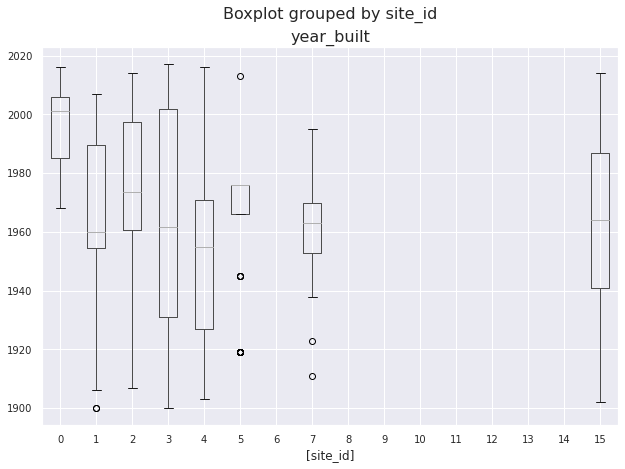

In [8]:
boxplot = building.boxplot(column=['year_built'], by=['site_id'],figsize= (10,7))

In [9]:
## removing columns with more than 50% NANs
building=building.drop(columns=['year_built','floor_count']);

In [10]:
del boxplot,boxplot1
gc.collect()

22385

# Join tables 


In [11]:
# Merge dataset to create training dataframe

train_buil = train.merge(building, on='building_id', how='left')
data_train = train_buil.merge(weather_train, on=['site_id','timestamp'], how='left')
data_train['timestamp'] = pd.to_datetime(data_train.timestamp, format='%Y-%m-%d %H:%M:%S')

del weather_train,train,train_buil
data_train.head(10)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
5,5,0,2016-01-01,0.0,0,Education,8000,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
6,6,0,2016-01-01,0.0,0,Lodging/residential,27926,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
7,7,0,2016-01-01,0.0,0,Education,121074,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
8,8,0,2016-01-01,0.0,0,Education,60809,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
9,9,0,2016-01-01,0.0,0,Office,27000,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [12]:
# Merge dataset to create test dataframe
test_buil = test.merge(building, on='building_id', how='left')
data_test = test_buil.merge(weather_test, on=['site_id','timestamp'], how='left')

del weather_test,test_buil

data_test.head(10)

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
5,5,5,0,2017-01-01 00:00:00,0,Education,8000,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
6,6,6,0,2017-01-01 00:00:00,0,Lodging/residential,27926,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
7,7,7,0,2017-01-01 00:00:00,0,Education,121074,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
8,8,7,1,2017-01-01 00:00:00,0,Education,121074,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
9,9,8,0,2017-01-01 00:00:00,0,Education,60809,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


## Dataframes description

In [13]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   meter               int8          
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   site_id             int8          
 5   primary_use         object        
 6   square_feet         int32         
 7   air_temperature     float16       
 8   cloud_coverage      float16       
 9   dew_temperature     float16       
 10  precip_depth_1_hr   float16       
 11  sea_level_pressure  float16       
 12  wind_direction      float16       
 13  wind_speed          float16       
dtypes: datetime64[ns](1), float16(7), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 964.0+ MB


In [14]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   meter               int8          
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   site_id             int8          
 5   primary_use         object        
 6   square_feet         int32         
 7   air_temperature     float16       
 8   cloud_coverage      float16       
 9   dew_temperature     float16       
 10  precip_depth_1_hr   float16       
 11  sea_level_pressure  float16       
 12  wind_direction      float16       
 13  wind_speed          float16       
dtypes: datetime64[ns](1), float16(7), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 964.0+ MB


In [15]:
missing_statistics(data_train) 
# the cloud_coverage columns contains alot of missing values

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,20216100,0.00
1,meter,0,20216100,0.00
2,timestamp,0,20216100,0.00
3,meter_reading,0,20216100,0.00
4,site_id,0,20216100,0.00
5,primary_use,0,20216100,0.00
6,square_feet,0,20216100,0.00
7,air_temperature,96658,20216100,0.48
8,cloud_coverage,8825365,20216100,43.66
9,dew_temperature,100140,20216100,0.50


In [16]:
missing_statistics(data_test) 
# the cloud_coverage columns contains alot of missing values 

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,row_id,0,41697600,0.00
1,building_id,0,41697600,0.00
2,meter,0,41697600,0.00
3,timestamp,0,41697600,0.00
4,site_id,0,41697600,0.00
5,primary_use,0,41697600,0.00
6,square_feet,0,41697600,0.00
7,air_temperature,221901,41697600,0.53
8,cloud_coverage,19542180,41697600,46.87
9,dew_temperature,260799,41697600,0.63


In [17]:
O, C = data_test.shape
print(f'Dans test, il y a {O} observations et {C} colonnes.')

Dans test, il y a 41697600 observations et 14 colonnes.


In [18]:
O, C = data_train.shape
print(f'Dans train, il y a {O} observations et {C} colonnes.') 

Dans train, il y a 20216100 observations et 14 colonnes.


### Deleting cloud_coverage column 

In [19]:
data_train=data_train.drop(columns=['cloud_coverage']);
data_test=data_test.drop(columns=['cloud_coverage']);

# Rows processing


In [20]:
liste = data_train.isnull().sum(axis=1).tolist()#liste with the number of nans in each row

RowsEQUAL,RowsANDHIGH=[],[]
for n in range(0,8):
    RowsEQUAL.append(round(sum( i == n for i in liste)/data_train.shape[0]*100,3))
    RowsANDHIGH.append(round(sum(i > n for i in liste)/data_train.shape[0]*100,3))

Rows_Statistics = pd.DataFrame(RowsEQUAL, columns=["% Rows with NANs (=)"])
Rows_Statistics[" % Rows with NANs (>)"] = RowsANDHIGH
Rows_Statistics.index.name = 'Number of NANs'
#df.index += 1 
print(Rows_Statistics);

del RowsEQUAL,RowsANDHIGH
del Rows_Statistics

                % Rows with NANs (=)   % Rows with NANs (>)
Number of NANs                                             
0                             74.017                 25.983
1                             20.544                  5.440
2                              4.770                  0.670
3                              0.192                  0.477
4                              0.007                  0.470
5                              0.022                  0.449
6                              0.449                  0.000
7                              0.000                  0.000


In [21]:
# Keep only the rows with at least 8 non-NAN values # 6 NAN or plus
data_train = data_train.dropna(thresh = 8) 

In [22]:
o, c = data_train.shape
print(f'Dans test apres suppression , il y a {o} observations et {c} colonnes.') #20216100

Dans test apres suppression , il y a 20125334 observations et 13 colonnes.


In [23]:
print("Nombre de lignes supprimées : " + str(O-o))

Nombre de lignes supprimées : 90766


In [24]:
# number of rows deleted
features = data_train.columns
print(f'Les {C} colonnes sont: ', list(features))
 

Les 14 colonnes sont:  ['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id', 'primary_use', 'square_feet', 'air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']


In [25]:
data_train.timestamp.unique  #train data is for 1 year


<bound method Series.unique of 0          2016-01-01 00:00:00
1          2016-01-01 00:00:00
2          2016-01-01 00:00:00
3          2016-01-01 00:00:00
4          2016-01-01 00:00:00
                   ...        
20216095   2016-12-31 23:00:00
20216096   2016-12-31 23:00:00
20216097   2016-12-31 23:00:00
20216098   2016-12-31 23:00:00
20216099   2016-12-31 23:00:00
Name: timestamp, Length: 20125334, dtype: datetime64[ns]>

In [26]:
data_test.timestamp.unique  #test data for 2 years

<bound method Series.unique of 0           2017-01-01 00:00:00
1           2017-01-01 00:00:00
2           2017-01-01 00:00:00
3           2017-01-01 00:00:00
4           2017-01-01 00:00:00
                   ...         
41697595    2018-05-09 07:00:00
41697596    2018-05-09 07:00:00
41697597    2018-05-09 07:00:00
41697598    2018-05-09 07:00:00
41697599    2018-05-09 07:00:00
Name: timestamp, Length: 41697600, dtype: object>

In [27]:
pd.to_datetime(data_train.timestamp, format='%Y-%m-%d %H:%M:%S').dt.time.astype(str).unique()
#meter reading for each hour

array(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
       '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00',
       '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
       '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00',
       '20:00:00', '21:00:00', '22:00:00', '23:00:00'], dtype=object)

# weather plotboxs


In [28]:
data_train["datetime"] = pd.to_datetime(data_train["timestamp"])
data_train["hour"] = data_train["datetime"].dt.hour;
data_train["day"] = data_train["datetime"].dt.day;
data_train["week"] = data_train["datetime"].dt.week;
data_train["month"] = data_train["datetime"].dt.month;


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


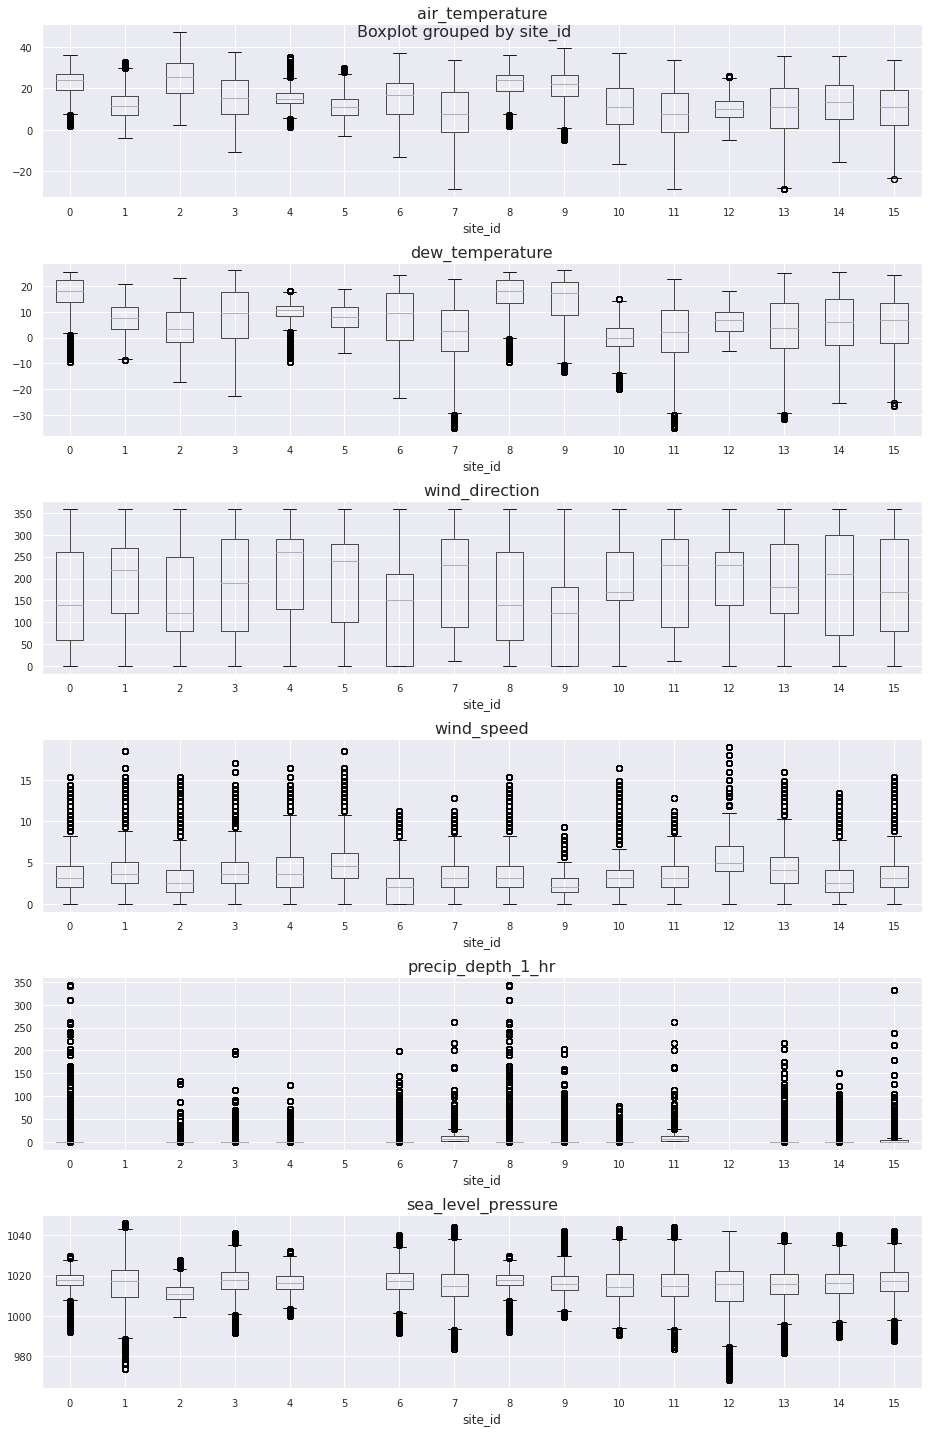

In [29]:
fig, axes = plt.subplots(6,1,figsize=(13,20)) 
for i,col in enumerate(['air_temperature','dew_temperature','wind_direction','wind_speed','precip_depth_1_hr', 'sea_level_pressure']):

    plot = data_train.boxplot(col, by="site_id", ax=axes.flatten()[i]);

plt.tight_layout() ;


We notice a lack of data for some entire Sit, in terms of  'precip depth' and 'sea level pressure'. While for outliers we notice a large number of outliers especially in 'precip depth'

# Filling in missing data using the mean
### in terms of 'site_id', 'hour' and 'month'

In [30]:
data_train = data_train.set_index(['site_id','hour','month'])

In [31]:
#filling air temperature
air_temperature_filler = pd.DataFrame(data_train.groupby(['site_id','hour','month'])['air_temperature'].mean(),columns=["air_temperature"])
data_train.update(air_temperature_filler,overwrite=False)
del air_temperature_filler

In [32]:
#filling due temperature
due_temperature_filler = pd.DataFrame(data_train.groupby(['site_id','hour','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
data_train.update(due_temperature_filler,overwrite=False)
del due_temperature_filler


In [33]:
# filling sea_level_pressure
sea_level_filler = pd.DataFrame(data_train.groupby(['site_id','hour','month'])['sea_level_pressure'].mean(),columns=['sea_level_pressure'])

data_train.update(sea_level_filler,overwrite=False)
del sea_level_filler

In [34]:
gc.collect()

20

In [35]:
#filling wind_direction
wind_direction_filler =  pd.DataFrame(data_train.groupby(['site_id','hour','month'])['wind_direction'].mean(),columns=['wind_direction'])
data_train.update(wind_direction_filler,overwrite=False)
del wind_direction_filler

In [36]:
#filling  wind speed
wind_speed_filler =  pd.DataFrame(data_train.groupby(['site_id','hour','month'])['wind_speed'].mean(),columns=['wind_speed'])
data_train.update(wind_speed_filler,overwrite=False)
del wind_speed_filler
gc.collect()

0

In [37]:
#filling precip depth
precip_depth_filler = pd.DataFrame(data_train.groupby(['site_id','hour','month'])['precip_depth_1_hr'].mean(),columns=['precip_depth_1_hr'])
data_train.update(precip_depth_filler,overwrite=False)
del precip_depth_filler


In [38]:
gc.collect()

20

In [39]:
data_train.reset_index(inplace=True)

In [40]:
missing_statistics(data_train) 

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,site_id,0,20125334,0.0
1,hour,0,20125334,0.0
2,month,0,20125334,0.0
3,building_id,0,20125334,0.0
4,meter,0,20125334,0.0
5,timestamp,0,20125334,0.0
6,meter_reading,0,20125334,0.0
7,primary_use,0,20125334,0.0
8,square_feet,0,20125334,0.0
9,air_temperature,0,20125334,0.0


In [41]:
gc.collect()

60

# Consumption measures

In [42]:
data_train['meter'].unique()
#{0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

array([0, 3, 1, 2], dtype=int8)

In [43]:
data_train['meter'].value_counts().unique() #observations per feature [0,1,2,3]

array([12017137,  4160093,  2686678,  1261426])

In [44]:
data_train[data_train['meter']== 3]["meter"].value_counts()

3    1261426
Name: meter, dtype: int64

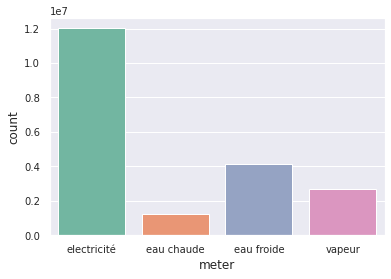

In [45]:
data_train['meter'].replace({0:"electricité",1:"eau froide",2:"vapeur",3:"eau chaude"},inplace=True)
sns.countplot(x= "meter",data = data_train,palette ="Set2");

# Test data description 

In [46]:
data_test.describe().transpose() #observations

,count,mean,std,min,25%,50%,75%,max
row_id,41697600.0,2.084880e+07,1.203706e+07,0.00000,1.042440e+07,2.084880e+07,3.127320e+07,4.169760e+07
building_id,41697600.0,8.075824e+02,4.297680e+02,0.00000,4.047500e+02,9.000000e+02,1.194250e+03,1.448000e+03
meter,41697600.0,6.642857e-01,9.278067e-01,0.00000,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
site_id,41697600.0,8.086134e+00,5.134712e+00,0.00000,3.000000e+00,9.000000e+00,1.300000e+01,1.500000e+01
square_feet,41697600.0,1.069469e+05,1.160888e+05,283.00000,3.224350e+04,7.226250e+04,1.383875e+05,8.750000e+05
air_temperature,41475699.0,NaN,0.000000e+00,-28.09375,7.800781e+00,1.670312e+01,2.390625e+01,4.831250e+01
dew_temperature,41436801.0,NaN,0.000000e+00,-31.59375,0.000000e+00,8.898438e+00,1.670312e+01,2.670312e+01
precip_depth_1_hr,33896037.0,NaN,NaN,-1.00000,0.000000e+00,0.000000e+00,0.000000e+00,5.970000e+02
sea_level_pressure,39180774.0,NaN,NaN,972.00000,1.011500e+03,1.016000e+03,1.020500e+03,1.050000e+03
wind_direction,38718937.0,NaN,NaN,0.00000,8.000000e+01,1.800000e+02,2.800000e+02,3.600000e+02


In [47]:
missing_statistics(data_test)


,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,row_id,0,41697600,0.00
1,building_id,0,41697600,0.00
2,meter,0,41697600,0.00
3,timestamp,0,41697600,0.00
4,site_id,0,41697600,0.00
5,primary_use,0,41697600,0.00
6,square_feet,0,41697600,0.00
7,air_temperature,221901,41697600,0.53
8,dew_temperature,260799,41697600,0.63
9,precip_depth_1_hr,7801563,41697600,18.71


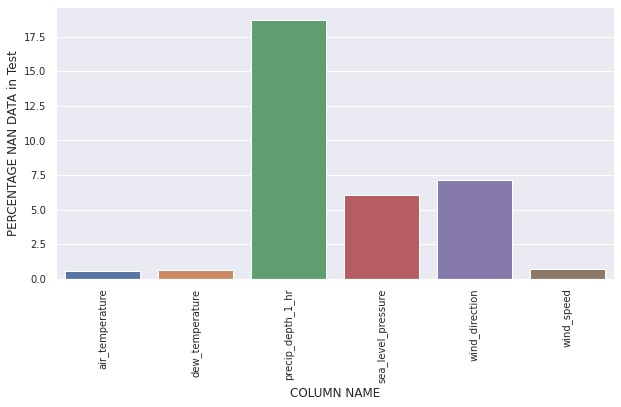

In [48]:
    nullseries = data_test.isnull().sum()
    onlynull= nullseries[nullseries > 0]
    plt.figure(figsize=(10,5));
    sns.barplot(x=onlynull.index , y=onlynull*100/len(data_test));
    plt.ylabel("PERCENTAGE NAN DATA in Test")
    plt.xlabel("COLUMN NAME");
    plt.xticks(rotation=90);

# Visualisations

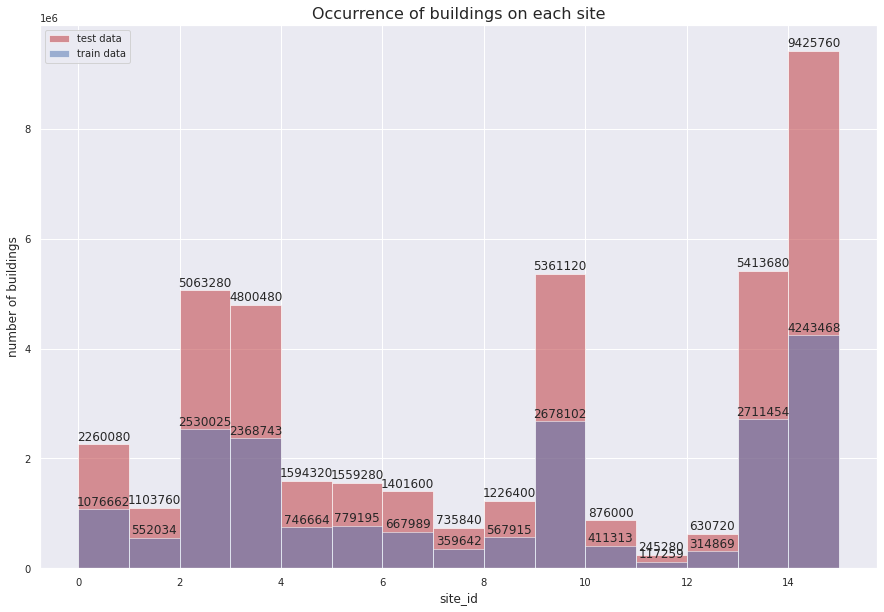

In [49]:
fig, ax = plt.subplots(1, figsize=(15, 10))
lab1 = ['train data']
lab2 = ['test data']
n, bins, patches = ax.hist(data_test.site_id, bins=15,color='r', edgecolor='white',alpha=0.6,label = lab2)
n1, bins1, patches1 = ax.hist(data_train.site_id, bins=15,color='b', edgecolor='white',alpha=0.5,label = lab1)

# Annotate each bar with the no. of buildings in that site:
for number, b in zip(n, bins[:-1]):
    ax.annotate(int(number), 
                 xy=(b+.5, number), xytext=(0, 1),#1 point vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12)
# Annotate each bar with the no. of buildings in that site:
for number1, b1 in zip(n1, bins1[:-1]):
    ax.annotate(int(number1), 
                 xy=(b1 +.5, number1), xytext=(0, 1),#1 point vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12)

ax.legend(prop ={'size': 10}) 
ax.set_xlabel('site_id')
ax.set_ylabel('number of buildings')
ax.set_title('Occurrence of buildings on each site', fontsize=16);


In [50]:
# Get a list of primary uses and its length
prim_use_list = data_train['primary_use'].unique()
len(prim_use_list)

16

In [51]:
building.groupby(['primary_use','site_id']).size().unstack().fillna(0).astype(int).style.background_gradient(axis=None)
building.groupby(['primary_use']).size().to_frame('number_buildings').fillna(0).style.background_gradient(axis=None)

,number_buildings
primary_use,
Education,549
Entertainment/public assembly,184
Food sales and service,5
Healthcare,23
Lodging/residential,147
Manufacturing/industrial,12
Office,279
Other,25
Parking,22


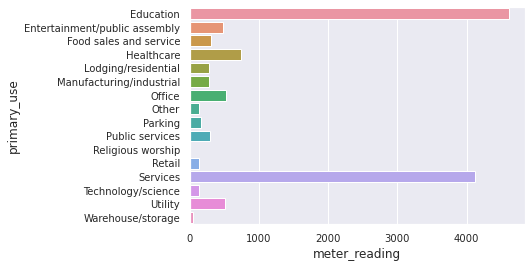

In [52]:
use = data_train.groupby("primary_use").meter_reading.mean()
sns.barplot(y=use.index,x=use)
del use

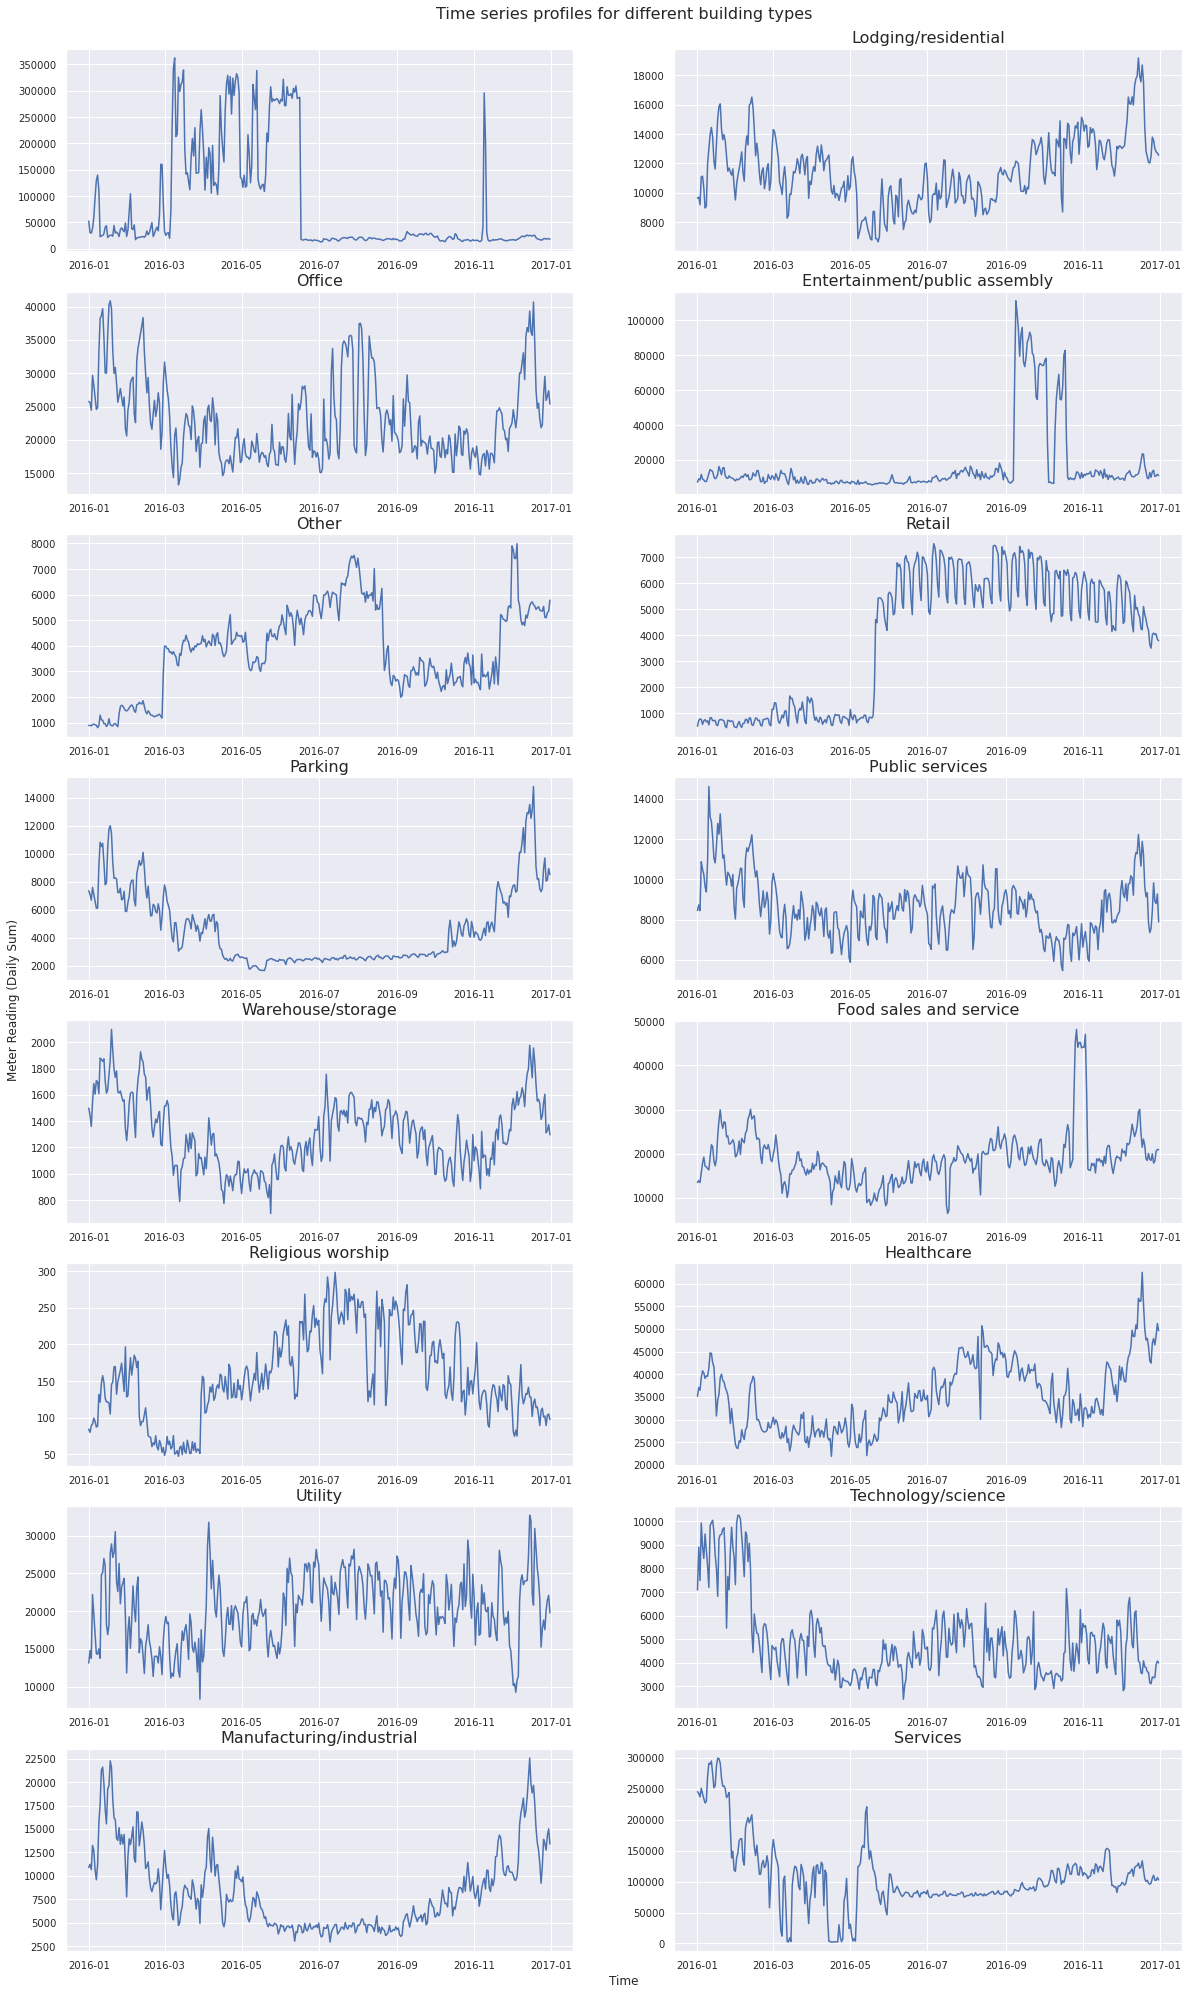

In [53]:

# Group by primary use and plot time series profiles
fig, axes = plt.subplots(8, 2, figsize=(20, 35))


# Daily energy use for each building
edu_daily = data_train.groupby(['building_id', data_train['timestamp'].dt.date])['meter_reading'].sum()
edu_daily = edu_daily.reset_index()
edu_mean = edu_daily.groupby('timestamp')['meter_reading'].mean()
axes[0, 0].plot(edu_mean.index, edu_mean)

# For the rest of the building types we will write a loop for batch ploting:
for ax, use in zip(axes.flat[1:], prim_use_list[1:]): 
    prim_use_df = data_train[data_train['primary_use']==use]
    prim_use_daily = prim_use_df.groupby(['building_id', prim_use_df['timestamp'].dt.date])['meter_reading'].sum()
    prim_use_daily = prim_use_daily.reset_index()
    mean = prim_use_daily.groupby('timestamp')['meter_reading'].mean()
    
    ax.plot(mean.index, mean)
    ax.set_title(use)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time')
plt.ylabel('Meter Reading (Daily Sum)', labelpad=20)

plt.title('Time series profiles for different building types', pad=30)
plt.show()

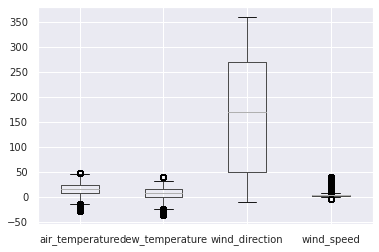

In [54]:
boxplot = data_train.boxplot(column=['air_temperature','dew_temperature','wind_direction','wind_speed']);

In [55]:
del building , boxplot, fig, prim_use_daily 
gc.collect()

4348

In [56]:
data_test["datetime"] = pd.to_datetime(data_test["timestamp"])
data_test["hour"] = data_test["datetime"].dt.hour;
data_test["month"] = data_test["datetime"].dt.month;
data_test["day"] = data_test["datetime"].dt.day;

In [57]:
drop_features = ["datetime"] 

data_train.drop(drop_features, axis=1, inplace=True)
data_test.drop(drop_features, axis=1, inplace=True)
del drop_features

In [58]:
data_train['meter'].replace({"electricité":0,"eau froide":1,"vapeur":2,"eau chaude":3},inplace=True)


In [59]:
data_test['meter'].replace({"electricité":0,"eau froide":1,"vapeur":2,"eau chaude":3},inplace=True)


TypeError: Cannot compare types 'ndarray(dtype=int8)' and 'str'

In [60]:
gc.collect()

20

# Save processed data in the output 

In [61]:
data_train.to_csv('data_training.csv', index=False)


In [62]:
data_test.to_csv('test_data.csv', index=False)